In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
from lightgbm import LGBMClassifier

import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize

nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

text     0
toxic    0
dtype: int64
0


<Axes: >

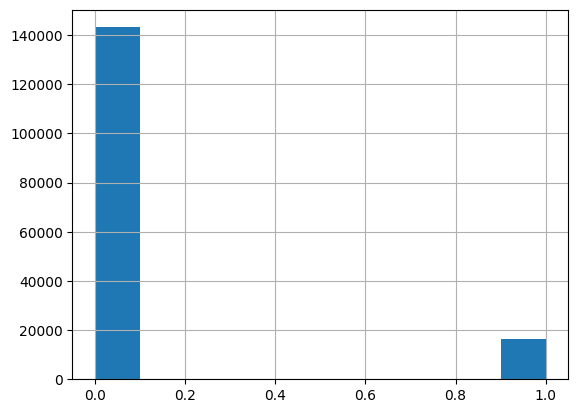

In [ ]:
data = pd.read_csv('toxic_comments (1).csv')

# Удалим неинформативный столбец
data = data.drop('Unnamed: 0', axis=1)

# Проверка на пропуски и дубликаты
print(data.isna().sum())
print(data.duplicated().sum())

# Распределение классов
data['toxic'].hist()


In [ ]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clear_and_lemmatize(text):
    text = re.sub(r'[^a-zA-Z ]', ' ', text)
    tokens = word_tokenize(text.lower())
    tagged = pos_tag(tokens)
    lemmatized = [
        lemmatizer.lemmatize(word, get_wordnet_pos(tag))
        for word, tag in tagged if word not in stop_words
    ]
    return ' '.join(lemmatized)

tqdm.pandas()
data['lemm_text'] = data['text'].astype(str).progress_map(clear_and_lemmatize)


  0%|          | 0/159292 [00:00<?, ?it/s]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    data, data['toxic'], test_size=0.4, random_state=12345
)

corpus_train = X_train['lemm_text']
corpus_test = X_test['lemm_text']

tfidf = TfidfVectorizer(stop_words='english')
X_train_tfidf = tfidf.fit_transform(corpus_train)
X_test_tfidf = tfidf.transform(corpus_test)


In [ ]:
# ----- 1. Logistic Regression -----
pipe_lr = Pipeline([
    ('model', LogisticRegression(solver='saga', max_iter=300, random_state=12345, class_weight='balanced'))
])

param_dist_lr = {
    'model__C': [0.01, 0.1, 1, 10],
    'model__penalty': ['l2'],
}

search_lr = RandomizedSearchCV(
    pipe_lr,
    param_distributions=param_dist_lr,
    n_iter=2,
    cv=2,
    scoring='f1',
    n_jobs=-1,
    verbose=1,
    random_state=123
)

search_lr.fit(X_train_tfidf, y_train)
print("LogReg CV F1:", search_lr.best_score_)


# ----- 2. LightGBM -----
pipe_lgbm = Pipeline([
    ('model', LGBMClassifier(random_state=12345))
])

param_dist_lgbm = {
    'model__num_leaves': [31, 50, 70],
    'model__max_depth': [10, 15, -1],      # -1 — без ограничения
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__n_estimators': [100, 150, 200],
    'model__class_weight': ['balanced']
}

search_lgbm = RandomizedSearchCV(
    pipe_lgbm,
    param_distributions=param_dist_lgbm,
    n_iter=3,
    cv=2,
    scoring='f1',
    n_jobs=-1,
    verbose=1,
    random_state=123
)

search_lgbm.fit(X_train_tfidf, y_train)
print("LGBM CV F1:", search_lgbm.best_score_)


# ----- 3. Выбираем лучшую модель -----
if search_lgbm.best_score_ > search_lr.best_score_:
    best_model = search_lgbm.best_estimator_
    print("Выбрана модель: LightGBM")
else:
    best_model = search_lr.best_estimator_
    print("Выбрана модель: LogisticRegression")


Fitting 2 folds for each of 2 candidates, totalling 4 fits


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogReg CV F1: 0.7497426620872196
Fitting 2 folds for each of 3 candidates, totalling 6 fits


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 9652, number of negative: 85923
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 17.809368 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 411178
[LightGBM] [Info] Number of data points in the train set: 95575, number of used features: 8184
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

In [ ]:
y_pred = best_model.predict(X_test_tfidf)
f1 = f1_score(y_test, y_pred)
print("F1 на тестовой выборке:", f1)

F1 на тестовой выборке: 0.755939524838013
